## 1. Ovreview of images

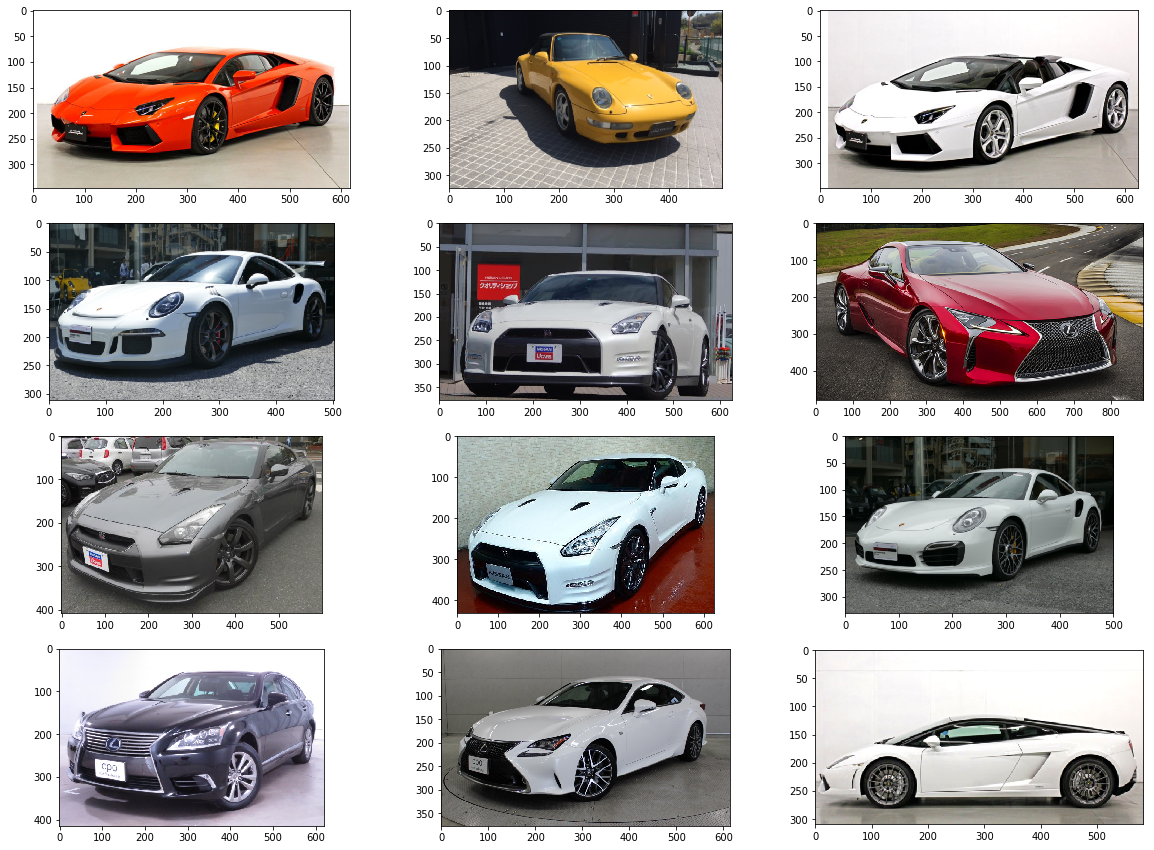

In [29]:
# Read Images
imm = []
for image in pred :   
    im= mpimg.imread(image)
    imm.append(im)
plt.figure(figsize=(20,15))

for i in range(len(imm)):
    plt.subplot(4,3, i+1)
    plt.imshow(imm[i]) 

##  2. Import library

In [1]:
import os
import h5py
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import time
import glob
import json
import csv
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import keras
from keras import applications
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D,Cropping2D 
from keras.layers import Activation, Dropout, Flatten, Dense, Lambda, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import RMSprop,Adam
from keras.models import Model

#number of class
n=4

Using TensorFlow backend.


## 3. Prepare dataset

In [2]:
# load training data of A
images = glob.glob('GTR/train/LEX/*')
trainA=[]
for image in images:
    trainA.append(image)

# Read A Images
trainAim = []
from keras.preprocessing import image
for images in trainA: 
    img = image.load_img(images, target_size=(224, 224))
    x = image.img_to_array(img)
    trainAim.append(x)
print(np.shape(trainAim))   


(100, 224, 224, 3)


In [3]:
# load training data of B
images = glob.glob('GTR/train//GTR/*')
trainB=[]
for image in images:
    trainB.append(image)

# Read B Images
trainBim = []
from keras.preprocessing import image
for images in trainB: 
    img = image.load_img(images, target_size=(224, 224))
    x = image.img_to_array(img)
    trainBim.append(x)
print(np.shape(trainBim))   

(100, 224, 224, 3)


In [4]:
# load training data of C
images = glob.glob('GTR/train/POR/*')
trainC=[]
for image in images:
    trainC.append(image)

# Read C Images
trainCim = []
from keras.preprocessing import image
for images in trainC: 
    img = image.load_img(images, target_size=(224, 224))
    x = image.img_to_array(img)
    trainCim.append(x)
print(np.shape(trainCim))   

(100, 224, 224, 3)


In [5]:
# load training data of D
images = glob.glob('GTR/train/LAM/*')
trainD=[]
for image in images:
    trainD.append(image)

# Read D Images
trainDim = []
from keras.preprocessing import image
for images in trainD: 
    img = image.load_img(images, target_size=(224, 224))
    x = image.img_to_array(img)
    trainDim.append(x)
print(np.shape(trainDim))   


(100, 224, 224, 3)


In [6]:
# load validation data of A
images = glob.glob('GTR/validation/LEX/*')
validationA=[]
for image in images:
    validationA.append(image)

# Read A Images
validationAim = []
from keras.preprocessing import image
for images in validationA: 
    img = image.load_img(images, target_size=(224, 224))
    x = image.img_to_array(img)
    validationAim.append(x)
print(np.shape(validationAim))   

(20, 224, 224, 3)


In [7]:
# load validation data of B
images = glob.glob('GTR/validation/GTR/*')
validationB=[]
for image in images:
    validationB.append(image)

# Read B Images
validationBim = []
from keras.preprocessing import image
for images in validationB: 
    img = image.load_img(images, target_size=(224, 224))
    x = image.img_to_array(img)
    validationBim.append(x)
print(np.shape(validationBim))   

(20, 224, 224, 3)


In [8]:
# load validation data of C
images = glob.glob('GTR/validation/POR/*')
validationC=[]
for image in images:
    validationC.append(image)

# Read C Images
validationCim = []
from keras.preprocessing import image
for images in validationC: 
    img = image.load_img(images, target_size=(224, 224))
    x = image.img_to_array(img)
    validationCim.append(x)
print(np.shape(validationCim))   

(20, 224, 224, 3)


In [9]:
# load validation data of D
images = glob.glob('GTR/validation/LAM/*')
validationD=[]
for image in images:
    validationD.append(image)

# Read D Images
validationDim = []
from keras.preprocessing import image
for images in validationD: 
    img = image.load_img(images, target_size=(224, 224))
    x = image.img_to_array(img)
    validationDim.append(x)
print(np.shape(validationDim))   

(20, 224, 224, 3)


In [10]:
#Create train data
X_train = np.vstack((trainAim,trainBim,trainCim,trainDim))
X_train=X_train/255.
X_test= np.vstack((validationAim,validationBim,validationCim,validationDim))
X_test=X_test/255.
#X_train = preprocess_input(X_train)

print(np.shape(X_train))
print(np.shape(X_test))

(400, 224, 224, 3)
(80, 224, 224, 3)


In [11]:
#Create label data
y_train = np.hstack(   (np.zeros(len(X_train)//n), np.ones(len(X_train)//n), np.ones(len(X_train)//n)*2, np.ones(len(X_train)//n)*3)  )
y_test =  np.hstack(   (np.zeros(len(X_test)//n), np.ones(len(X_test)//n), np.ones(len(X_test)//n)*2, np.ones(len(X_test)//n)*3)    )

In [12]:
# Make categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(np.shape(y_train))
print(np.shape(y_test ))

(400, 4)
(80, 4)


## 4. Extract features by ResNet152 on TFHub, train FC model 

In [13]:
module = hub.Module("https://tfhub.dev/google/imagenet/resnet_v1_152/feature_vector/1")
height, width = hub.get_expected_image_size(module)

INFO:tensorflow:Using /var/folders/17/xnzg1kxs39qfhxw9x8bdb83r0000gn/T/tfhub_modules to cache modules.
Instructions for updating:
Colocations handled automatically by placer.


In [14]:
features = module(X_train) 

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [15]:
with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  message_embeddings = session.run(module(X_train))


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [16]:
print(type(message_embeddings))
print(np.shape(message_embeddings))
message_embeddings[0,:]

<class 'numpy.ndarray'>
(400, 2048)


array([0.      , 0.001733, 0.      , ..., 0.      , 0.      , 0.275106],
      dtype=float32)

In [17]:
features1 = module(X_test) 

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [18]:
with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  message_embeddings1 = session.run(module(X_test))

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [19]:
print(type(message_embeddings1))
print(np.shape(message_embeddings1))
message_embeddings1[0,:]

<class 'numpy.ndarray'>
(80, 2048)


array([0.        , 0.11481927, 0.020595  , ..., 0.41720247, 0.10255356,
       0.10306339], dtype=float32)

In [20]:
X_train=message_embeddings
X_test=message_embeddings1

model = Sequential()
model.add(Dense(4, input_dim=2048, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 8196      
Total params: 8,196
Trainable params: 8,196
Non-trainable params: 0
_________________________________________________________________


In [21]:
t=time.time()

model.compile(optimizer=Adam(lr=1e-3),
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_data=[X_test, y_test])
                   
#model.save_weights('model.h5')

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict')

Instructions for updating:
Use tf.cast instead.
Train on 400 samples, validate on 80 samples
Epoch 1/30
400/400 [==============================] - 89s 222ms/step - loss: 1.3515 - acc: 0.3925 - val_loss: 1.1922 - val_acc: 0.5000
Epoch 2/30
400/400 [==============================] - 0s 439us/step - loss: 0.8233 - acc: 0.7100 - val_loss: 0.8863 - val_acc: 0.6625
Epoch 3/30
400/400 [==============================] - 0s 272us/step - loss: 0.5938 - acc: 0.8175 - val_loss: 0.7722 - val_acc: 0.7250
Epoch 4/30
400/400 [==============================] - 0s 362us/step - loss: 0.4788 - acc: 0.8725 - val_loss: 0.6961 - val_acc: 0.7750
Epoch 5/30
400/400 [==============================] - 0s 234us/step - loss: 0.4027 - acc: 0.8950 - val_loss: 0.6390 - val_acc: 0.8000
Epoch 6/30
400/400 [==============================] - 0s 190us/step - loss: 0.3415 - acc: 0.9300 - val_loss: 0.5997 - val_acc: 0.8375
Epoch 7/30
400/400 [==============================] - 0s 300us/step - loss: 0.2980 - acc: 0.9400 - val

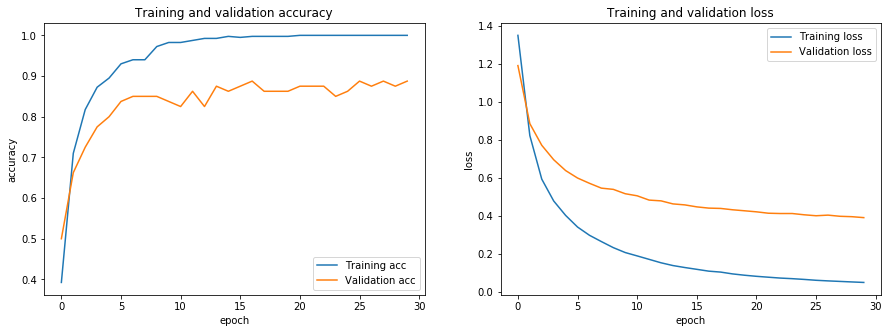

In [22]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
            
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.show()

## 5. Deploy created model and obtain prediction on new images

In [25]:
# load prediction data 
images = glob.glob('GTR/predict/*')
pred=[]
for image in images:
    pred.append(image)

# Read prediction Images
prediction = []
from keras.preprocessing import image
for imm in pred: 
    img = image.load_img(imm, target_size=(224, 224))
    x = image.img_to_array(img)
    prediction.append(x)
print(np.shape(prediction))   

(12, 224, 224, 3)


In [26]:
prediction=np.array(prediction)
prediction=prediction/255.

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  message_embeddings2 = session.run(module(prediction ))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [27]:
print(type(message_embeddings2))
print(np.shape(message_embeddings2))
message_embeddings2[0,:]

<class 'numpy.ndarray'>
(12, 2048)


array([0.        , 0.        , 0.46137   , ..., 0.10271832, 0.006689  ,
       0.        ], dtype=float32)

In [28]:
t=time.time()

prediction=message_embeddings2

nb=12
result=[]
for i in range(nb):
    pp = np.asarray(prediction[i])
    transformed_image_array =  pp[None, :]
    predict = model.predict(transformed_image_array, batch_size=1)
    predict= np.argmax(predict)
    result.append(predict)

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict')

result

41.98612 Seconds to predict


[3, 2, 3, 1, 1, 0, 1, 0, 2, 0, 0, 1]